In [58]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation



In [59]:
#  Auxiliary functions :

###############################################################################

def evolve(X):
    ''' Evolves a board of Game of Life for one turn '''
    # Dead cells as a boundary condition
    # Count neighbours
    # Alive if 3 neighbours or 2 neighbours and already alive
    
    Xi = X.astype(int)
    neigh = np.zeros(Xi.shape)
    neigh[1:-1,1:-1] = (Xi[:-2,:-2]  + Xi[:-2,1:-1] + Xi[:-2,2:] + 
                        Xi[1:-1,:-2] +                Xi[1:-1,2:]  + 
                        Xi[2:,:-2]   + Xi[2:,1:-1]  + Xi[2:,2:]) 
    
    return np.logical_or(neigh==3,np.logical_and(Xi==1,neigh==2))

###############################################################################

def get_history(B,T):
    ''' Returns the evolution of a board B after T generations '''
    history = np.zeros((T,B.shape[0], B.shape[1]),dtype=bool)
    for t in range(T):
        history[t,:,:] = B
        B = evolve(B)   
       #print(t)
    return history    

###############################################################################
    
def plotcells(X, filename=False):
    ''' Plots a board of Game of Life + optionally saving the figure '''
    LW = 0.5
    if(X.shape[0]>200): 
        USE_IMSHOW = True
    else:
        USE_IMSHOW = False
        
    fig = plt.figure(figsize=(16,16),dpi=120)    
    if USE_IMSHOW == False:    
        # Light blue lines as cells boundaries
        plt.pcolor(X.T, cmap="gray_r",
                   edgecolors='cadetblue', linewidths=LW)
    else:
        plt.imshow(X[:,::-1].T, cmap="gray_r")        
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    fig.tight_layout()
    
    if (filename != False): 
        plt.savefig(filename,dpi=90)
    else:
        plt.show()
    
###############################################################################
    
def makeMovie(history,filename,trim=False):
    ''' Create the movie from a history of a game of life'''
    # History is the boolean history (non inverted i.e. True = alive)
    # Inversion is done in the colormap
    # Filename should be *.mp4
    
    FIGSIZE = (16,16)
    DPI = 240
    LW = 0.5
    
    
    if(history.shape[1]>200): 
        USE_IMSHOW = True
    else:
        USE_IMSHOW = False
        
    # Trim boundaries
    if trim: 
        history = history[:,3:-3,3:-3]
    
    # Create the plot and its starting point
    print("Create initial plot")
    my_cmap = plt.get_cmap('gray_r')
    fig = plt.figure(figsize=FIGSIZE,dpi=DPI)
    ax = fig.add_subplot(111)
    
    if USE_IMSHOW == False:
    # First option : use pcolor
        pc = ax.pcolor(history[0,:,:].T, cmap=my_cmap,
                       edgecolors='cadetblue', linewidths=LW)
    else:        
    # Second option : use imshow
        im  = ax.imshow(history[0,:,::-1].T, cmap=my_cmap)
    
    #cnt = ax.text(0.01, 0.99, str(0),color='darkblue', fontsize=30,
            #verticalalignment='top', horizontalalignment='left',
            #transform=ax.transAxes)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    
    
    # The function as it is called at the n-th iteration
    # It directly modifies the data within the image
    def update_img(n):
        # Revert and scale from 0-1 to 0-255

        if USE_IMSHOW == False:
            new_color = my_cmap(255*history[n,:,:].T.ravel()) 
            pc.update({'facecolors':new_color})
        else:
            im.set_data(history[n,:,::-1].T)
        #
        #cnt.set_text(str(n))
 
    
        return True
    
    # Create the animation and save it
    print("Make animation")
    ani = animation.FuncAnimation(fig, update_img, history.shape[0], 
                                  interval=15) 
    writer = animation.FFMpegWriter(fps=3, bitrate=5000)
    print("Save movie")
    #ani.save(filename, writer = writer, dpi=DPI) 
    #ani.save('basic_animation.mp4', writer = writer, dpi=DPI) 
    ani.save(filename, writer = writer, dpi=DPI) 
    print("Saved")
    
###############################################################################


    
def readRLE(filename, Cshape=(50,50), position = (10,10), rH=False,rV=False,tp=False):
    
    ''' Read the RLE file and returns a binary matrix '''
    # see http://www.conwaylife.com/wiki/RLE 
    
    # Open file and cast it into a unique string
    f = open(filename,"r")
    s = ''
    while True:
        l = f.readline()
        if l == '':             # Empty indicates end of file. An empty line would be '\n'
            break
        if l[0] =='#':
            continue
        if l[0] =='x':
            continue
        s = s + l[:-1]   # To remove EOL
    f.close()
    
        
    # Create matrix
    SHAPE_MAX = (2500,2500)
    B = np.zeros(SHAPE_MAX).astype(bool)
    
    # We parse each character and decide accordingly what to do
    # If the character is a digit, we keep going until we reach 'b' or 'o'
    curX, curY = 0, 0
    qs = ''
    for c in s:
    
        # End of file
        if c=='':  
            break
        
        # Next Line
        if c=='$':
            q = 1 if qs=='' else int(qs)
            curY += q
            curX = 0
            qs = ''
        
        # Digit (check ascii code for a digit from 0 to 9)
        if ord(c)>47 and ord(c)<58:  #
            qs = qs + c
            
        # Alive (o) or Dead (b) cell    
        if c == 'b' or c=='o':
            q = 1 if qs=='' else int(qs)
            for i in range(q):
                B[curX, curY] = False if c=='b' else True
                curX += 1
            qs = ''
    
    
    
    
    
    posX, posY = position
    BshapeY=max(np.where(sum(B)>0)[0])+1
    BshapeX=max(np.where(sum(B.T)>0)[0])+1
    
    B = B[0:BshapeX,0:BshapeY]
    
    if rV:
        B=B[:,::-1]
    if rH:
        B=B[::-1,:]
    if tp:
        B=B.T
    
    C = np.zeros(Cshape)
    C[posX:(posX+B.shape[0]),posY:(posY+B.shape[1])] = np.copy(B)
    
    return C.astype(bool)

In [60]:

''' Initial board '''

B = np.random.choice(2,(60,60),p=[0.8,0.2]).astype(bool)

################################

def _main_(pattern,shapeY,pos,T,trim=False,rH=False, rV=False, tp=False):
    ''' Load a pattern from an RLE file, run evolution and make a movie
    Options :
    * pos = where to position the pattern on the board
    * rH, rV and tp to reverse horizontal, vertical or transpose the dimensions    
    * trim : trim edges for nicer plot    
    '''
    # 16/9 ratio
    shape = (int(1.78*shapeY),shapeY)
    
    # Read RLE file in the rle folder
    B = readRLE("rle/"+pattern+".rle", shape, pos,rH=rH,rV=rV, tp=tp)    
    history = get_history(B,T)

    makeMovie(history,"output/"+pattern+".mp4",trim=trim)

################################





Create initial plot
Make animation
Save movie
Saved


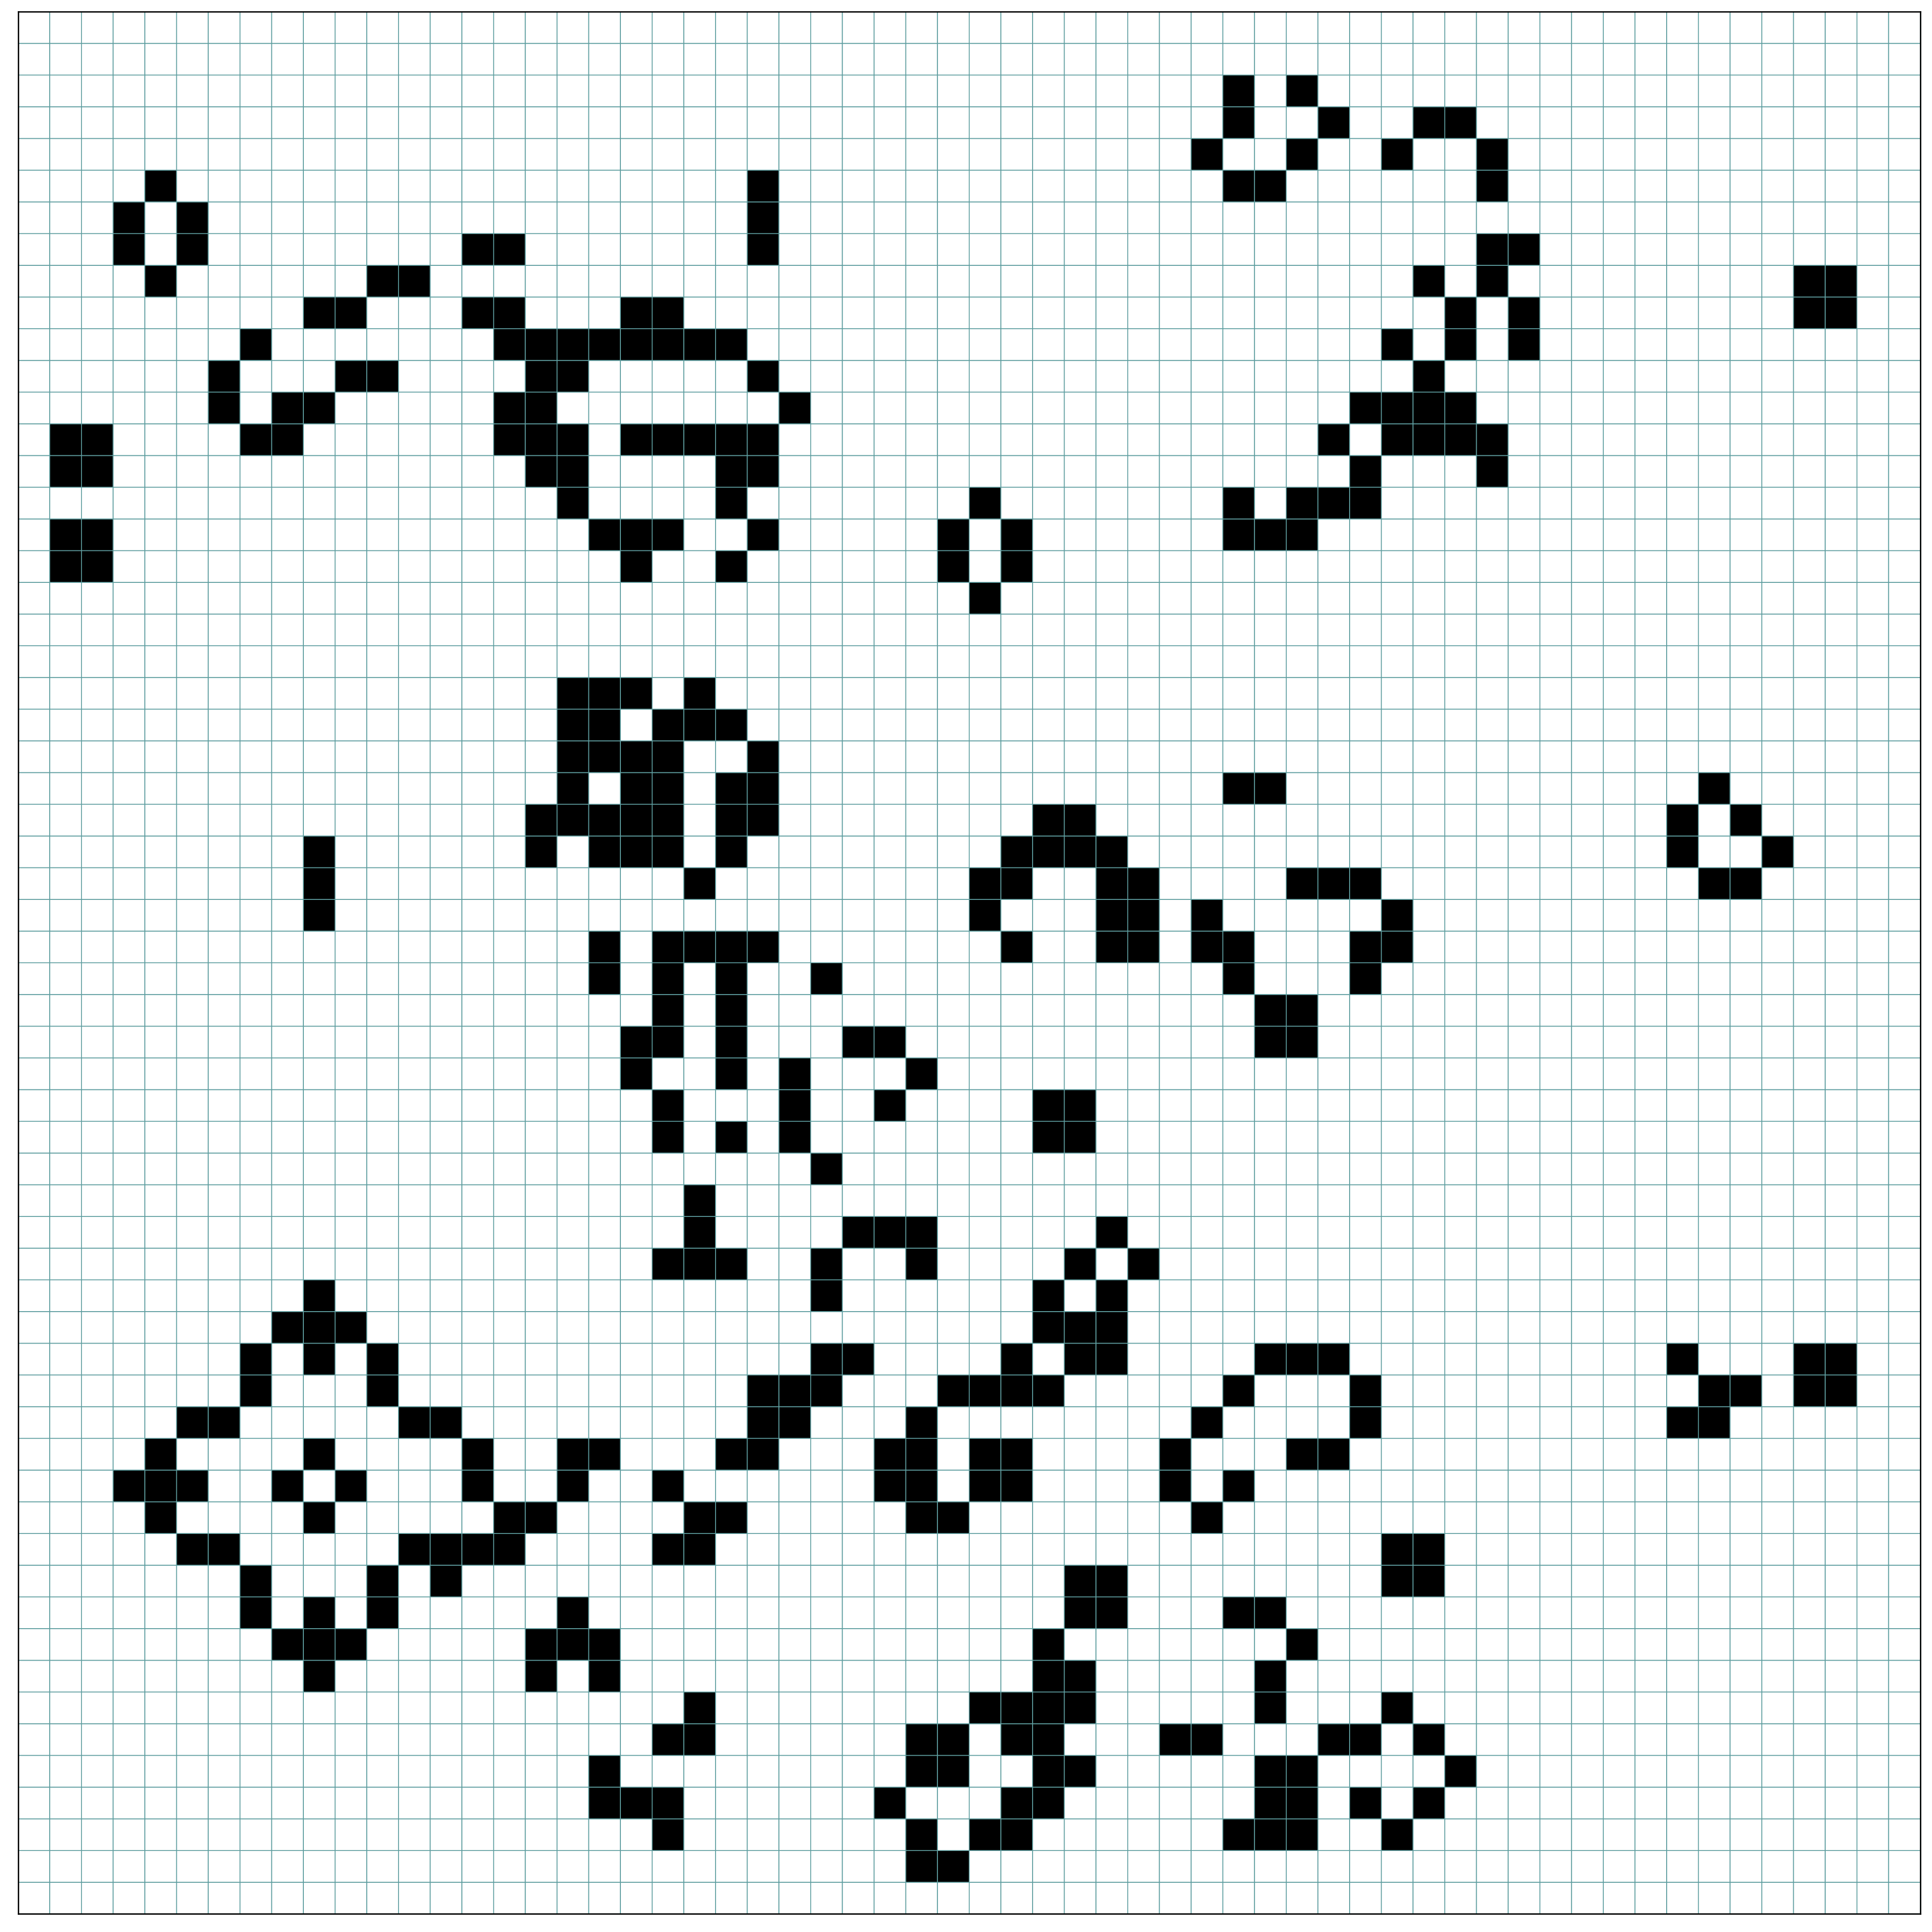

In [61]:
# Random board 60x60 with x% alive
x = 0.4
B = np.random.choice(2,(60,60),p=[1-x,x]).astype(bool)
history = get_history(B,100)
makeMovie(history,"output/"+'random'+".mp4",trim=False)

Create initial plot
Make animation
Save movie
Saved


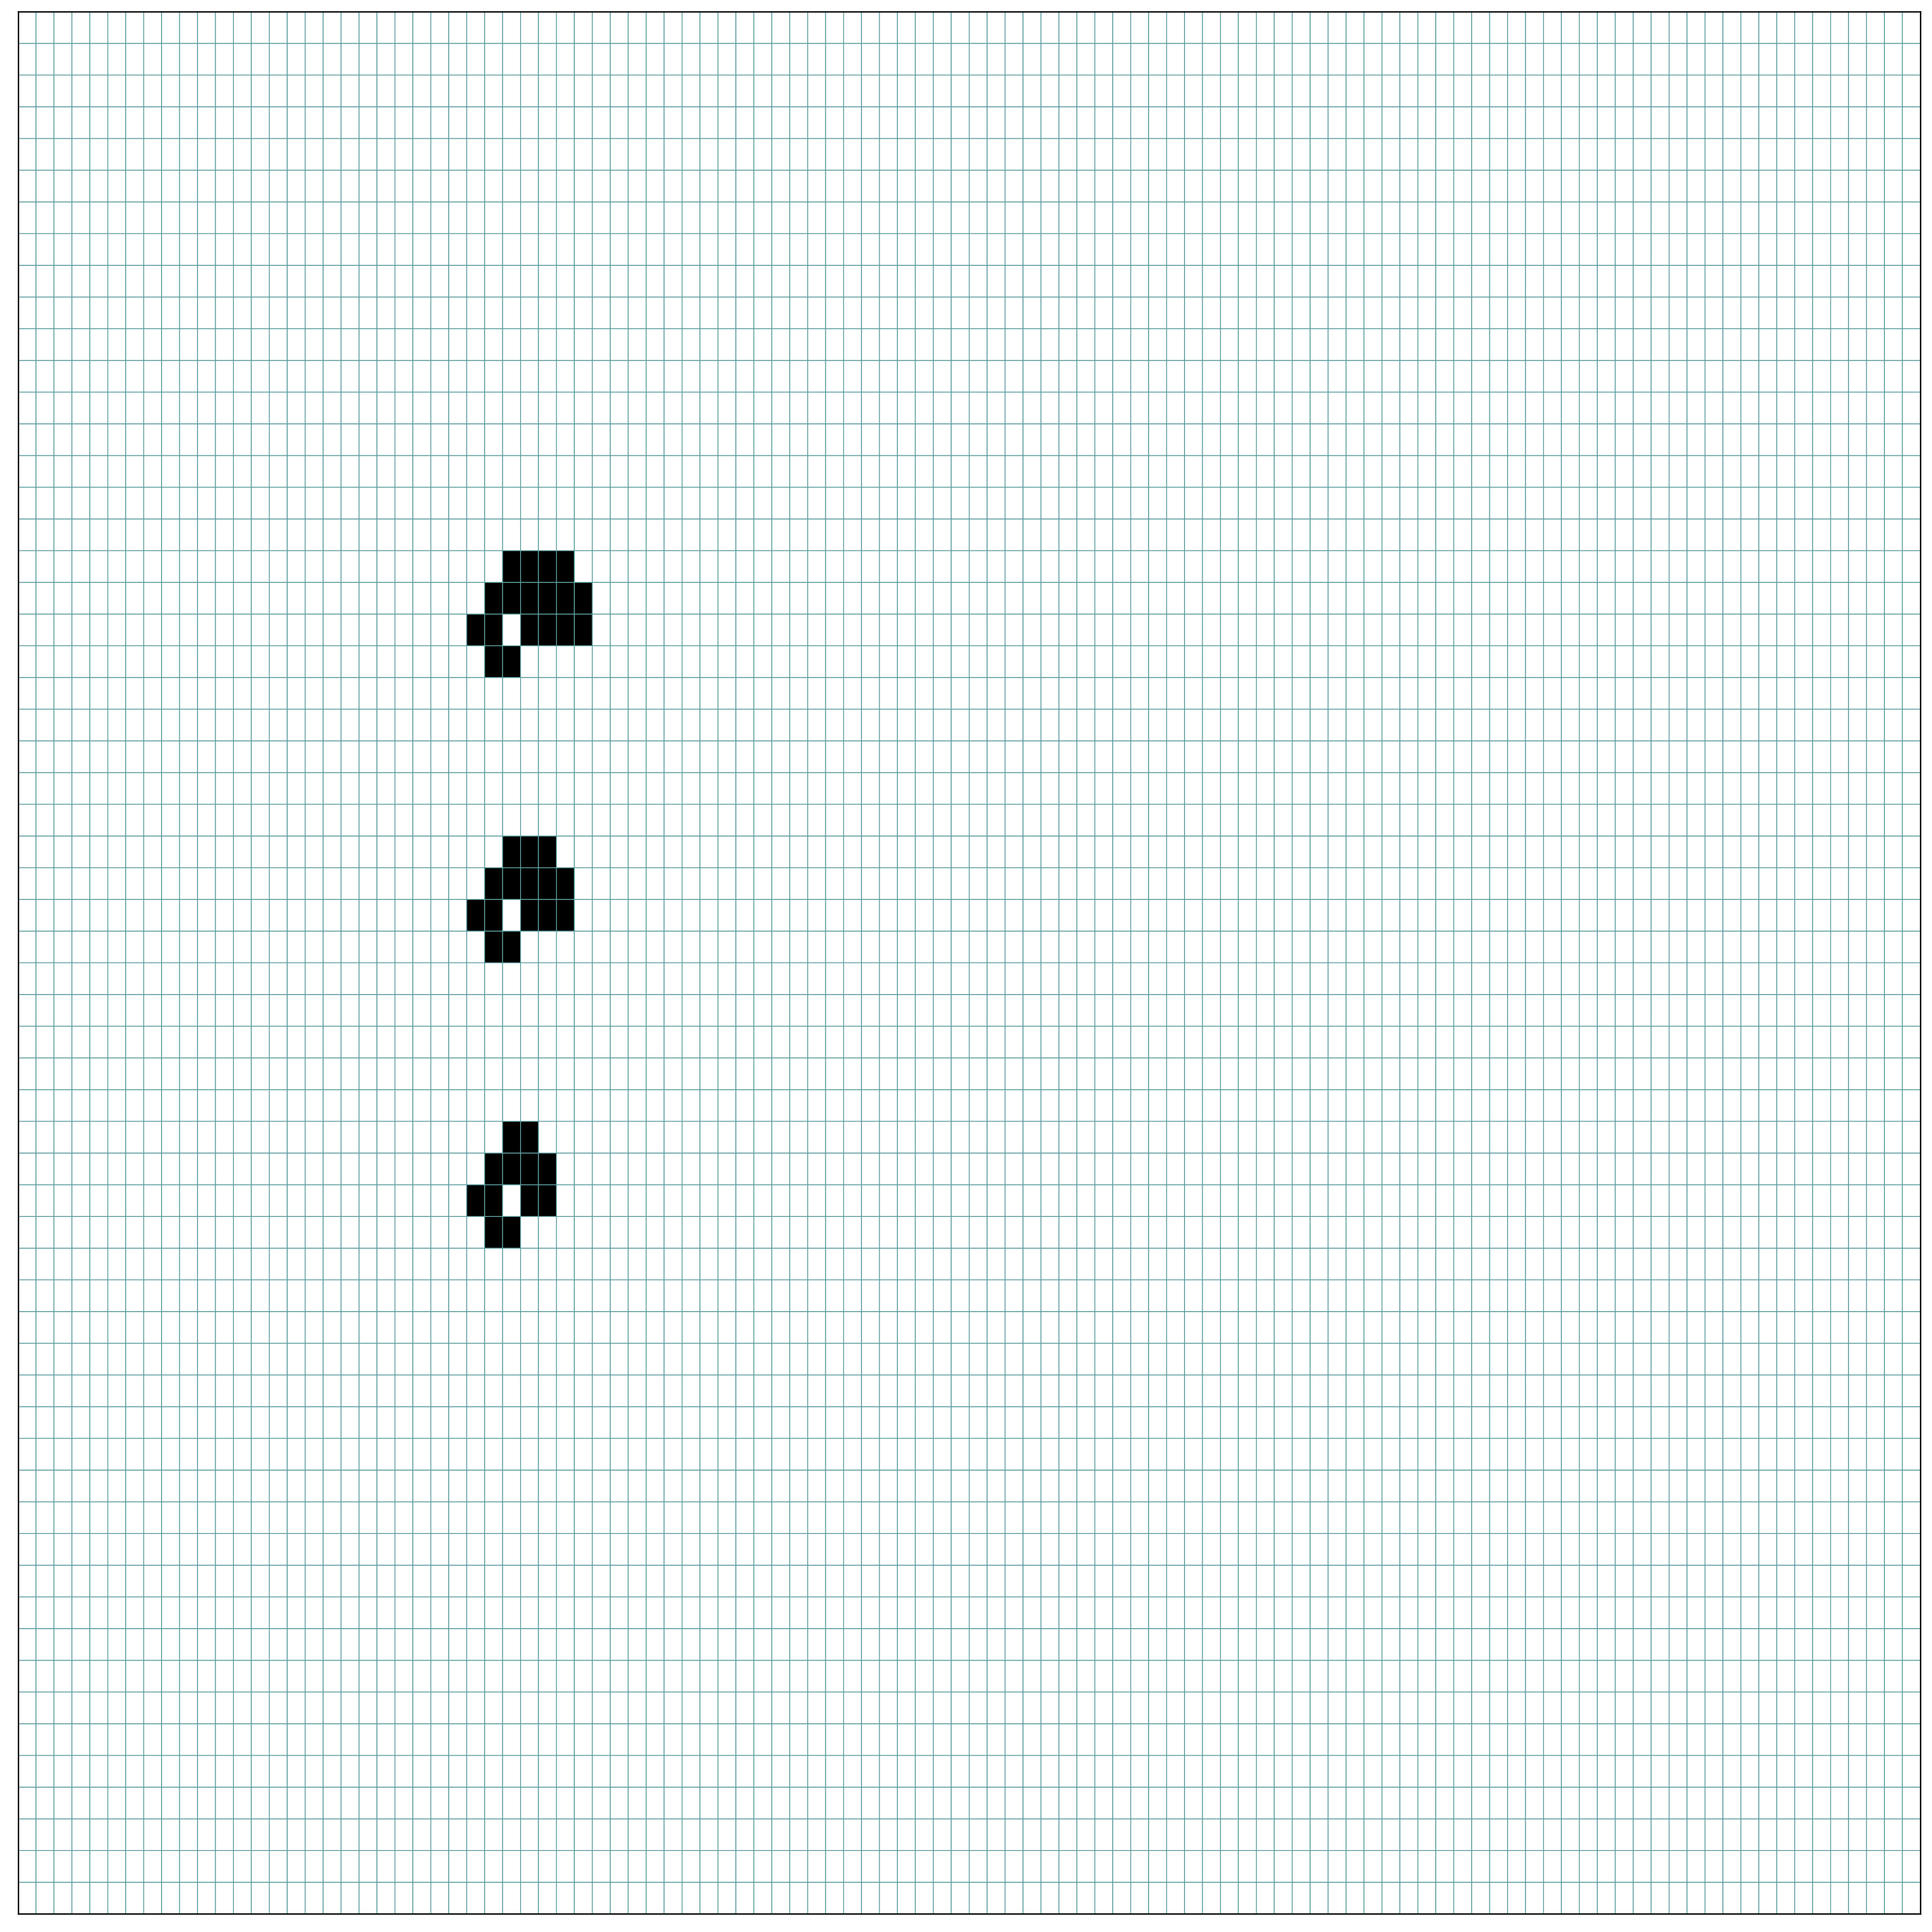

In [62]:
########## Spaceships ########## 

pattern = "spaceships"
shapeY = 60
pos = (60,20)
T = 70
_main_(pattern,shapeY,pos,T)

Create initial plot
Make animation
Save movie
Saved


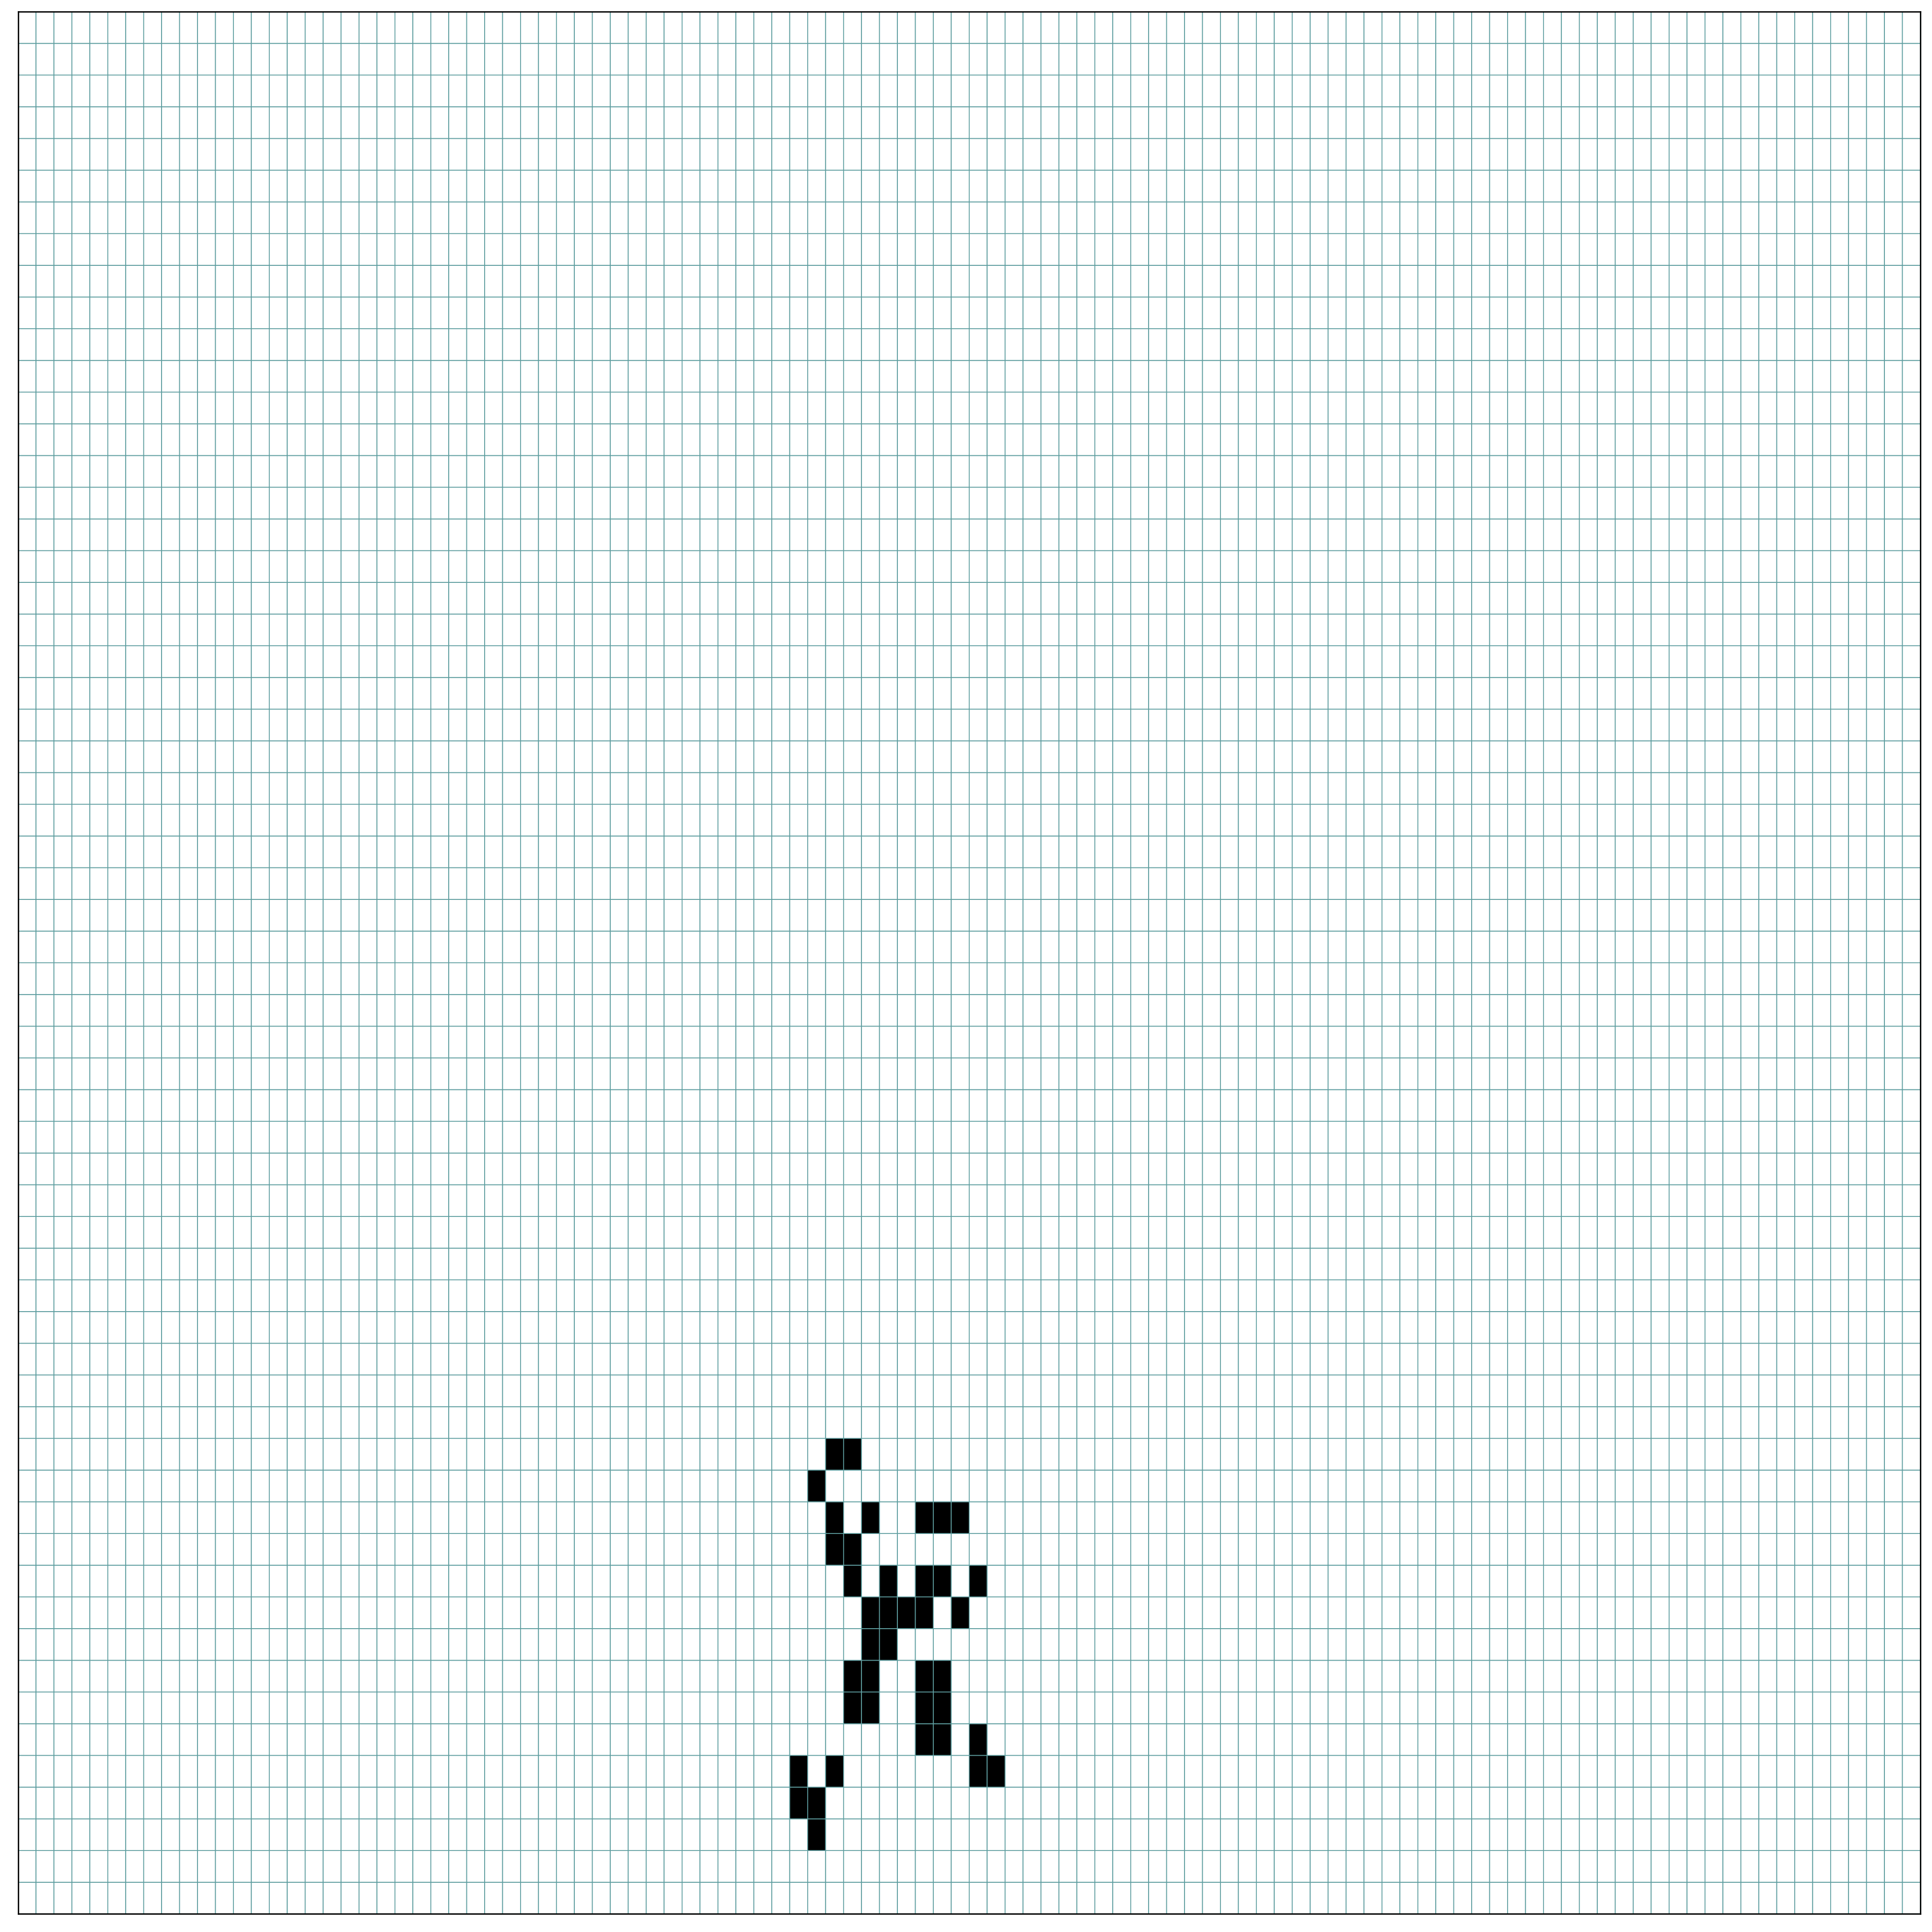

In [63]:
########## canadagoose ########## 

pattern = "canadagoose"
shapeY = 60
pos = (60,20)
T = 70
_main_(pattern,shapeY,pos,T)

In [ ]:
# For more pattern see the /rle